In [139]:
#Azmain's base code

# Final Plots Displaying Calculated Equivalent Widths and Component Gaussians
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import os
import shutil
from astropy.io import fits
import re
import numpy as np
#Plot stuff
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
import numpy as np
import matplotlib.pyplot as plt
#from specutils.io import read_fits
import pandas as pd
import glob
from lmfit import Model
from astropy.io import fits
from numpy import trapz
from astropy.time import Time
from PyAstronomy import pyasl
from getpass import getuser
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
print('Working on '+getuser()+'.')

#directories:
# main dir:
gdir = r'C:\Users\ZY\Documents\github\233boy\Dr.-Yep-2024-summer-research\\'

# Goodman normalized spectra:
gndir = gdir + '\GoodmanNormBest\\'

#open normalized data, return w,f norm, f wfun (unnormalized, for sigmav),head,bcv:
def opfitsg(name):
    print('returns: w,f,fun,head,bc')
    # One target against one standard:
    #def fitvsinilite(name,stdname,rvcent0=0,vsinistart0=0,skipedge0=0,prin='n',plotyn='n',pltcc='n'): #returns the essentials.
    #For standards test, you don't account for each standard's uncert.
    #target:
    hdu=fits.open(gndir+'n_'+name+'.fits') #.fits data
    dat=hdu[0].data
    head=hdu[0].header
    hdu.close()
    bc=bcvg(head) #barycentric correction
    w,f=dat #total spectrum
    #unnorm for sigmav
    wfunfile=head['WFUNFILE']
    hdu=fits.open(gdir+wfunfile) #.fits data
    fun=hdu[0].data[1] #unnorm spectrum
    hdu.close()
    return w,f,fun,head,bc

#Ultimate opendat:
def opendatt(dir,filename,spl=''): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    if spl=='':
        labels=dat[0][0:-1].split()
        dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    else:
        labels=dat[0][0:-1].split(spl)
        dat2=[[a.strip('\n') for a in d.split(spl)] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params,splitchar='',prin='y'): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    if splitchar=='':
        dat,label=opendatt(dirr,filename)
    else:
        dat,label=opendatt(dirr,filename,splitchar)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    if prin=='y':
        print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    if len(params)==1:
        varrs=varrs[0]
    return varrs

def writedat(dirr,filename,pars,label): #.dat auto included. pars as [name,ra,dec] etc.
    datp=[[str(a[i]) for a in pars] for i in range(len(pars[0]))]
    f=open(dirr+filename+'.dat','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
    f.close()
    print('It is written: '+filename+'.dat')


def read_excel(file_path, sheet_name: str, usecols: list, name: list):
    # 读取Excel文件中特定的工作表
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=usecols, skiprows=0, skipfooter=0)
    
    # 删除空白行
    df.dropna(how='all', inplace=True)

    # 将第一行非空白数据作为标题
    df.columns = df.iloc[0]
    df = df[1:]
    df.reset_index(drop=True, inplace=True)
    
    # Debugging: Print the DataFrame columns
    print("DataFrame columns:", df.columns)

    # Ensure column names are correct
    #df.columns = [col.strip() for col in df.columns]

    # Check if all names exist in the DataFrame columns
    for col in name:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Return the requested columns
    return [df[col] for col in name]
#mini normalizer
# 定义对数函数
def log_func(x, a, b):
    return a*x**b

Working on ZY.


In [54]:
temp_dir= r'C:\Users\ZY\Desktop'
dirr = temp_dir + '\\'
filename = 'Irradiated'
#print(np.array(x),np.array(y),np.ravel(yerr),np.array(z),np.ravel(zerr))
pars = [np.array(x),np.array(y),np.ravel(yerr),np.array(z),np.ravel(zerr)]
label= ['cluster', 'age','ageerr','accfrac','accfrac_err']


# Call the function
writedat(dirr, filename, pars, label)

#opendat(temp_dir+'\\',filename+'.dat',['cluster'])

['cluster', 'age', 'ageerr', 'accfrac', 'accfrac_err']
It is written: Irradiated.dat


DataFrame columns: Index(['cluster', 'age', 'accfrac'], dtype='object', name=2)
DataFrame columns: Index(['ageerr(+)'], dtype='object', name=2)
DataFrame columns: Index(['accfrac_err'], dtype='object', name=2)
DataFrame columns: Index(['accfrac', 'age'], dtype='object', name=2)
DataFrame columns: Index(['ageerr'], dtype='object', name=2)
DataFrame columns: Index(['accfrac_err'], dtype='object', name=2)


C:\Users\ZY\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


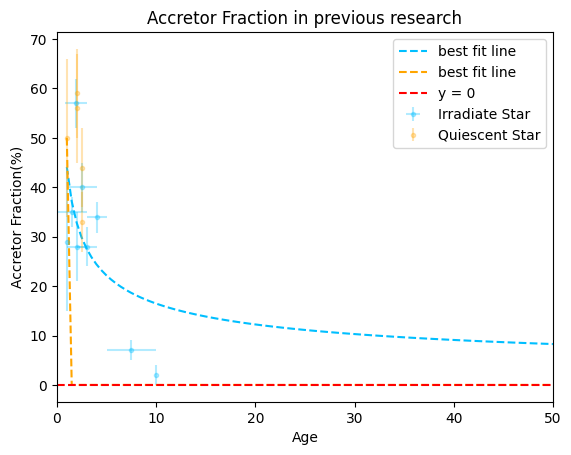

In [140]:
file_path=r'C:\Users\ZY\Desktop\RV_comparasion.xlsx'

#read the excel to get the name and spectral type
sheet_name='Changes'
x,y,z=read_excel(file_path, sheet_name, 'H,I,L', ['cluster','age','accfrac'])
y = np.array(y, dtype=float)
z = np.array(z, dtype=float)
yerr = read_excel(file_path, sheet_name, "J", ['ageerr(+)'])
zerr =read_excel(file_path, sheet_name, "M", ['accfrac_err'])

plt.errorbar(y,z,yerr=zerr,xerr=yerr,fmt='.', color='deepskyblue', label='Irradiate Star',alpha=0.3)
#plt.scatter(y,z,alpha=0.3)

# #annotation
# for i in range(len(x)):
#     plt.annotate(x[i], (y[i], z[i]), textcoords="offset points", xytext=(0,10), ha='center')
# 使用 curve_fit 进行拟合
params, params_covariance = curve_fit(log_func, y, z)
y_fit = np.linspace(min(y), 50, 100)
z_fit = log_func(y_fit, params[0], params[1])
plt.plot(y_fit,z_fit,'--',label="best fit line",color='deepskyblue')
plt.legend()


plt.xlabel('Age')
plt.ylabel('Accretor Fraction(%)')
plt.title('Accretor Fraction in previous research')
plt.xlim(0,50)


Q_y,Q_z=read_excel(file_path, sheet_name, 'E,B', ['age','accfrac'])
Q_y = np.array(Q_y, dtype=float)
Q_z = np.array(Q_z, dtype=float)
#Q_yerr= read_excel(file_path, sheet_name, "AA,AB", ['ageerr(+)','ageerr(-)'])
Q_yerr=read_excel(file_path, sheet_name, "F", ['ageerr'])
Q_zerr =read_excel(file_path, sheet_name, "C", ['accfrac_err'])
Q_zerr = np.array(Q_zerr, dtype=float)
plt.errorbar(Q_y,Q_z,yerr=Q_zerr,fmt='.', color='orange', label='Quiescent Star',alpha=0.3)

params, params_covariance = curve_fit(log_func, Q_y, Q_z)
Q_y_fit = np.linspace(min(Q_y), 50, 100)
Q_z_fit = log_func(Q_y_fit, params[0], params[1])
plt.plot(Q_y_fit,Q_z_fit,'--',label="best fit line",color='orange')
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')

plt.legend()

DataFrame columns: Index(['cluster', 'accfrac', 'age'], dtype='object', name=1)
DataFrame columns: Index(['ageerr(+)', 'ageerr(-)'], dtype='object', name=1)
DataFrame columns: Index(['accfrac_err'], dtype='object', name=1)
DataFrame columns: Index(['accfrac', 'age'], dtype='object', name=2)
DataFrame columns: Index(['ageerr'], dtype='object', name=2)
DataFrame columns: Index(['accfrac_err'], dtype='object', name=2)


C:\Users\ZY\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


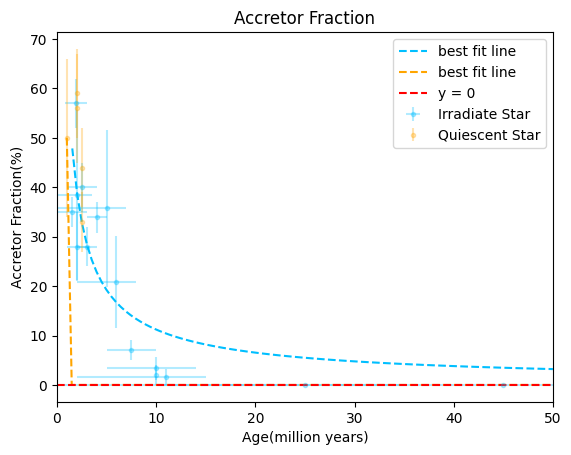

In [141]:
file_path=r'C:\Users\ZY\Desktop\RV_comparasion.xlsx'

#read the excel to get the name and spectral type
sheet_name='Accretor'
sheet_name1='Changes'
x,y,z=read_excel(file_path, sheet_name, 'W,AB,Z', ['cluster','age','accfrac'])
y = np.array(y, dtype=float)
z = np.array(z, dtype=float)
yerr1,yerr2 = read_excel(file_path, sheet_name, "AC,AD", ['ageerr(+)','ageerr(-)'])
zerr =read_excel(file_path, sheet_name, "AA", ['accfrac_err'])


#print(np.array(y),np.array(z),np.ravel(yerr1),np.ravel(yerr2),np.ravel(zerr))

plt.errorbar(y,z,yerr=zerr,xerr=[yerr1,yerr2],fmt='.', color='deepskyblue', label='Irradiate Star',alpha=0.3)
#plt.scatter(y,z,alpha=0.3)

# #annotation
# for i in range(len(x)):
#     plt.annotate(x[i], (y[i], z[i]), textcoords="offset points", xytext=(0,10), ha='center')
# 使用 curve_fit 进行拟合
params, params_covariance = curve_fit(log_func, y, z)
y_fit = np.linspace(min(y), 50, 100)
z_fit = log_func(y_fit, params[0], params[1])
plt.plot(y_fit,z_fit,'--',label="best fit line",color='deepskyblue')
plt.legend()


plt.xlabel('Age(million years)')
plt.ylabel('Accretor Fraction(%)')
plt.title('Accretor Fraction')
plt.xlim(0,50)


Q_y,Q_z=read_excel(file_path, sheet_name1, 'E,B', ['age','accfrac'])
Q_y = np.array(Q_y, dtype=float)
Q_z = np.array(Q_z, dtype=float)
#Q_yerr= read_excel(file_path, sheet_name, "AA,AB", ['ageerr(+)','ageerr(-)'])
Q_yerr=read_excel(file_path, sheet_name1, "F", ['ageerr'])
Q_zerr =read_excel(file_path, sheet_name1, "C", ['accfrac_err'])
Q_zerr = np.array(Q_zerr, dtype=float)
plt.errorbar(Q_y,Q_z,yerr=Q_zerr,fmt='.', color='orange', label='Quiescent Star',alpha=0.3)

params, params_covariance = curve_fit(log_func, Q_y, Q_z)
Q_y_fit = np.linspace(min(Q_y), 50, 100)
Q_z_fit = log_func(Q_y_fit, params[0], params[1])
plt.plot(Q_y_fit,Q_z_fit,'--',label="best fit line",color='orange')
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')

plt.legend()

DataFrame columns: Index(['cluster', 'accfrac', 'age'], dtype='object', name=1)
DataFrame columns: Index(['ageerr(+)', 'ageerr(-)'], dtype='object', name=1)
DataFrame columns: Index(['accfrac_err'], dtype='object', name=1)
[ 5.    2.   11.    6.   10.   45.   25.    1.55  1.9   2.    2.5   3.
  4.    7.5  10.  ] [35.71428571 38.46153846  1.63934426 20.83333333  3.33333333  0.
  0.         35.         57.         28.         40.         28.
 33.9         7.          2.        ] [5 2 9 4 5 55 15 1.45 1.1 1 1.5 1 1 2.5 0] [2 1.5 4 2 4 20 10 1.45 1.1 1 1.5 1 1 2.5 0] [15.971914124998499 17.200522903844536 1.639344262295082 9.316949906249123
 2.357022603955159 0 0 3 5 7 5 4 3.1 2 2]
DataFrame columns: Index(['accfrac', 'age'], dtype='object', name=2)
DataFrame columns: Index(['ageerr'], dtype='object', name=2)
DataFrame columns: Index(['accfrac_err'], dtype='object', name=2)


<ErrorbarContainer object of 3 artists>

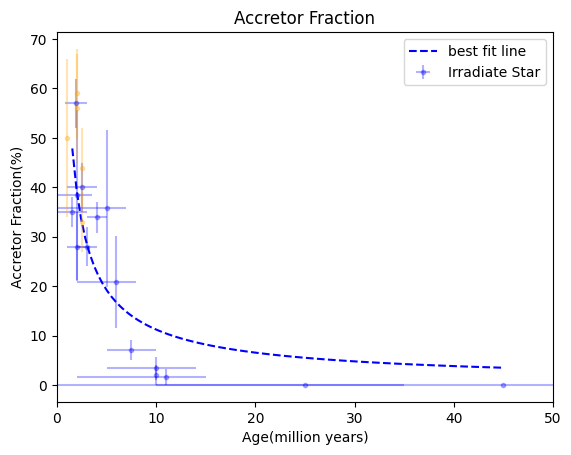

In [138]:
def power_law(x, a, b):
    return a*x**b
file_path=r'C:\Users\ZY\Desktop\RV_comparasion.xlsx'

#read the excel to get the name and spectral type
sheet_name='Accretor'
sheet_name1='Changes'
x,y,z=read_excel(file_path, sheet_name, 'W,AB,Z', ['cluster','age','accfrac'])
y = np.array(y, dtype=float)
z = np.array(z, dtype=float)
yerr1,yerr2 = read_excel(file_path, sheet_name, "AC,AD", ['ageerr(+)','ageerr(-)'])
zerr =read_excel(file_path, sheet_name, "AA", ['accfrac_err'])

x_data = y
y_data = z
x_errors = np.array(yerr1)
y_errors = np.ravel(zerr)
print(np.array(y),np.array(z),np.ravel(yerr1),np.ravel(yerr2),np.ravel(zerr))

plt.errorbar(y,z,yerr=zerr,xerr=[yerr1,yerr2],fmt='.', color='blue', label='Irradiate Star',alpha=0.3)
#plt.scatter(y,z,alpha=0.3)

# #annotation
# for i in range(len(x)):
#     plt.annotate(x[i], (y[i], z[i]), textcoords="offset points", xytext=(0,10), ha='center')
# 使用 curve_fit 进行拟合
params, params_covariance = curve_fit(power_law, y, z)
y_fit = np.linspace(min(y), max(y), 100)
z_fit = power_law(y_fit, params[0], params[1])
plt.plot(y_fit,z_fit,'--',label="best fit line",color='blue')
plt.legend()


plt.xlabel('Age(million years)')
plt.ylabel('Accretor Fraction(%)')
plt.title('Accretor Fraction')
plt.xlim(0,50)


Q_y,Q_z=read_excel(file_path, sheet_name1, 'E,B', ['age','accfrac'])
Q_y = np.array(Q_y, dtype=float)
Q_z = np.array(Q_z, dtype=float)
#Q_yerr= read_excel(file_path, sheet_name, "AA,AB", ['ageerr(+)','ageerr(-)'])
Q_yerr=read_excel(file_path, sheet_name1, "F", ['ageerr'])
Q_zerr =read_excel(file_path, sheet_name1, "C", ['accfrac_err'])
Q_zerr = np.array(Q_zerr, dtype=float)
plt.errorbar(Q_y,Q_z,yerr=Q_zerr,fmt='.', color='orange', label='Quiescent Star',alpha=0.3)

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.odr import ODR, Model, Data, RealData

# # Step 1: Import Necessary Libraries
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.odr import ODR, Model, Data, RealData

# # Step 2: Define the Linear Function
# def power_law_model(B, x):
#     a, b = B
#     return a * x**b

# # Step 3: Prepare Your Data
# # Example data
# # x_data = Q_y
# # y_data = Q_z
# # x_errors = Q_yerr
# # y_errors = Q_zerr

# # Step 3: Replace Zero Errors
# x_errors[x_errors == 0] = 1e-10  # Small positive value
# y_errors[y_errors == 0] = 1e-10  # Small positive value

# print(x_data,y_data,x_errors,y_errors)
# # Step 4: Use ODR for Fitting
# # Create a RealData object
# data = RealData(x_data, y_data, sx=x_errors, sy=y_errors)

# # Create a Model object
# model = Model(power_law_model)

# # Create an ODR object
# odr = ODR(data, model, beta0=[1., 1.])  # Initial guess for parameters

# # Perform the fit
# output = odr.run()

# # Extracting the parameters and their uncertainties
# a, b = output.beta
# a_err, b_err = np.sqrt(np.diag(output.cov_beta))

# # Print the results
# print(f"Coefficient (a) = {a:.3f} ± {a_err:.3f}")
# print(f"Exponent (b) = {b:.3f} ± {b_err:.3f}")

# # Step 5: Create a smooth x-axis for plotting
# x_smooth = np.linspace(min(x_data), max(x_data), 500)
# y_smooth = power_law_model([a, b], x_smooth)

# # Plot the Data and Fitted Line
# #plt.errorbar(x_data, y_data, xerr=x_errors, yerr=y_errors, fmt='o', label='Data with error bars')
# plt.plot(x_smooth, y_smooth, label=f'Fitted line: y = {a:.2f}*x^{b:.2f}')
# plt.legend()
# # plt.xlabel('x')
# # plt.ylabel('y')
# # plt.legend()
# # plt.show()

# # weight=1/Q
# # params, params_covariance = curve_fit(log_func, Q_y, Q_z)
# # Q_y_fit = np.linspace(min(Q_y), max(Q_y), 100)
# # Q_z_fit = log_func(Q_y_fit, params[0], params[1])
# # plt.plot(Q_y_fit,Q_z_fit,'--',label="best fit line",color='orange')
# # plt.legend()

DataFrame columns: Index(['cluster', 'age', 'accfrac'], dtype='object', name=2)
DataFrame columns: Index(['ageerr(+)'], dtype='object', name=2)
DataFrame columns: Index(['accfrac_err'], dtype='object', name=2)


TypeError: expected w and y to have the same length

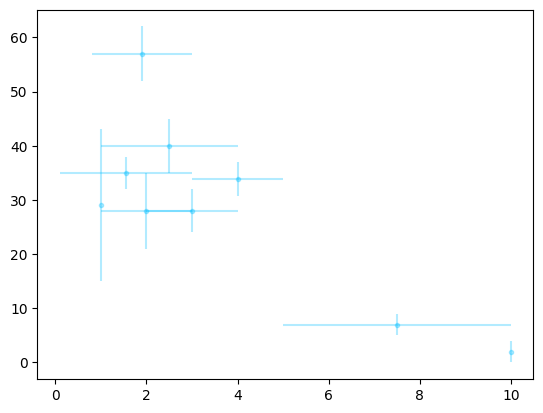

In [143]:
file_path=r'C:\Users\ZY\Desktop\RV_comparasion.xlsx'

#read the excel to get the name and spectral type
sheet_name='Changes'
x,y,z=read_excel(file_path, sheet_name, 'H,I,L', ['cluster','age','accfrac'])
y = np.array(y, dtype=float)
z = np.array(z, dtype=float)
yerr = read_excel(file_path, sheet_name, "J", ['ageerr(+)'])
zerr =read_excel(file_path, sheet_name, "M", ['accfrac_err'])

plt.errorbar(y,z,yerr=zerr,xerr=yerr,fmt='.', color='deepskyblue', label='Irradiate Star',alpha=0.3)
#plt.scatter(y,z,alpha=0.3)

# #annotation
# for i in range(len(x)):
#     plt.annotate(x[i], (y[i], z[i]), textcoords="offset points", xytext=(0,10), ha='center')
# 使用 curve_fit 进行拟合
yerr[yerr == 0] = 1e-10 
fit=np.polyfit(y,np.log10(z),1,w=1./np.array(yerr))
py = np.poly1d(fit)
plt.plot(y,py(y),'--',label="best fit line",color='deepskyblue')
plt.legend()


plt.xlabel('Age')
plt.ylabel('Accretor Fraction(%)')
plt.title('Accretor Fraction in previous research')
plt.xlim(0,50)


Q_y,Q_z=read_excel(file_path, sheet_name, 'E,B', ['age','accfrac'])
Q_y = np.array(Q_y, dtype=float)
Q_z = np.array(Q_z, dtype=float)
#Q_yerr= read_excel(file_path, sheet_name, "AA,AB", ['ageerr(+)','ageerr(-)'])
Q_yerr=read_excel(file_path, sheet_name, "F", ['ageerr'])
Q_zerr =read_excel(file_path, sheet_name, "C", ['accfrac_err'])
Q_zerr = np.array(Q_zerr, dtype=float)
plt.errorbar(Q_y,Q_z,yerr=Q_zerr,fmt='.', color='orange', label='Quiescent Star',alpha=0.3)

params, params_covariance = curve_fit(log_func, Q_y, Q_z)
Q_y_fit = np.linspace(min(Q_y), 50, 100)
Q_z_fit = log_func(Q_y_fit, params[0], params[1])
plt.plot(Q_y_fit,Q_z_fit,'--',label="best fit line",color='orange')
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')

plt.legend()